#### Inference (Generate)

In [3]:
%cd ControlNet/

d:\Controlnet\ControlNet


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import json
import numpy as np
from torch.utils.data import Dataset
from datasets import load_dataset

ds = load_dataset("Kelvin878/PCB_V2")


class MyDataset(Dataset):

    def __init__(self, hf_dataset):
        self.data = hf_dataset
        self.img_size = 512

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        source = item['guide'].resize(
            (self.img_size, self.img_size)).convert('RGB')
        target = item['image'].resize((self.img_size, self.img_size))

        source = np.array(source)
        target = np.array(target).astype(np.float32)
        prompt = item['text']

        # binarize source image
        # Normalize source images to [0, 1].
        source = np.where(source > 127, 1, 0).astype(np.float32)
        # Normalize target images to [-1, 1].
        target = (target / 127.5) - 1.0

        return dict(jpg=target, txt=prompt, hint=source)


dataset = MyDataset(ds['train'])

In [5]:
from cldm.model import create_model, load_state_dict
import cv2
from annotator.util import resize_image
import numpy as np
import torch
import einops
from cldm.ddim_hacked import DDIMSampler
from PIL import Image

# Configs
resume_path = 'lightning_logs/version_4/checkpoints/epoch=112-step=72884.ckpt'  # your checkpoint path
N = 1
ddim_steps = 50

model = create_model('./models/cldm_v21.yaml').cpu()
model.load_state_dict(load_state_dict(resume_path, location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v21.yaml]
Loaded state_dict from [lightning_logs/version_4/checkpoints/epoch=112-step=72884.ckpt]


In [54]:
def HWC3(x):
    assert x.dtype == np.uint8
    if x.ndim == 2:
        x = x[:, :, None]
    assert x.ndim == 3
    H, W, C = x.shape
    assert C == 1 or C == 3 or C == 4
    if C == 3:
        return x
    if C == 1:
        return np.concatenate([x, x, x], axis=2)
    if C == 4:
        color = x[:, :, 0:3].astype(np.float32)
        alpha = x[:, :, 3:4].astype(np.float32) / 255.0
        y = color * alpha + 255.0 * (1.0 - alpha)
        y = y.clip(0, 255).astype(np.uint8)
        return y


with torch.no_grad():
    if torch.cuda.is_available():
        model = model.cuda()

    ddim_sampler = DDIMSampler(model)
    # random sample a data from dataset
    data = dataset[np.random.randint(len(dataset))]

    input_image = (data['jpg'] * 127.5 + 127.5).astype(np.uint8)
    image_resolution = 512
    img = resize_image(HWC3(input_image), image_resolution)
    H, W, C = img.shape

    detected_map = (data['hint'] * 255).astype(np.uint8)
    num_samples = 1
    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, "b h w c -> b c h w").clone()

    seed = 5566

    prompt = data['txt']
    a_prompt = ''
    n_prompt = ''

    cond = {
        "c_concat": [control],
        "c_crossattn": [
            model.get_learned_conditioning([prompt + ", " + a_prompt] *
                                           num_samples)
        ],
    }
    un_cond = {
        # "c_concat": None if guess_mode else [control],
        "c_concat": [control],
        "c_crossattn":
        [model.get_learned_conditioning([n_prompt] * num_samples)],
    }
    shape = (4, H // 8, W // 8)

    ddim_steps = 50
    samples, intermediates = ddim_sampler.sample(
        ddim_steps,
        num_samples,
        shape,
        cond,
        verbose=False,
        eta=0.0,
        unconditional_guidance_scale=9.0,
        unconditional_conditioning=un_cond,
        show_progress=True,
    )

    x_samples = model.decode_first_stage(samples)
    x_samples = ((einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 +
                  127.5).cpu().numpy().clip(0, 255).astype(np.uint8))

    results = [x_samples[i] for i in range(num_samples)]

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


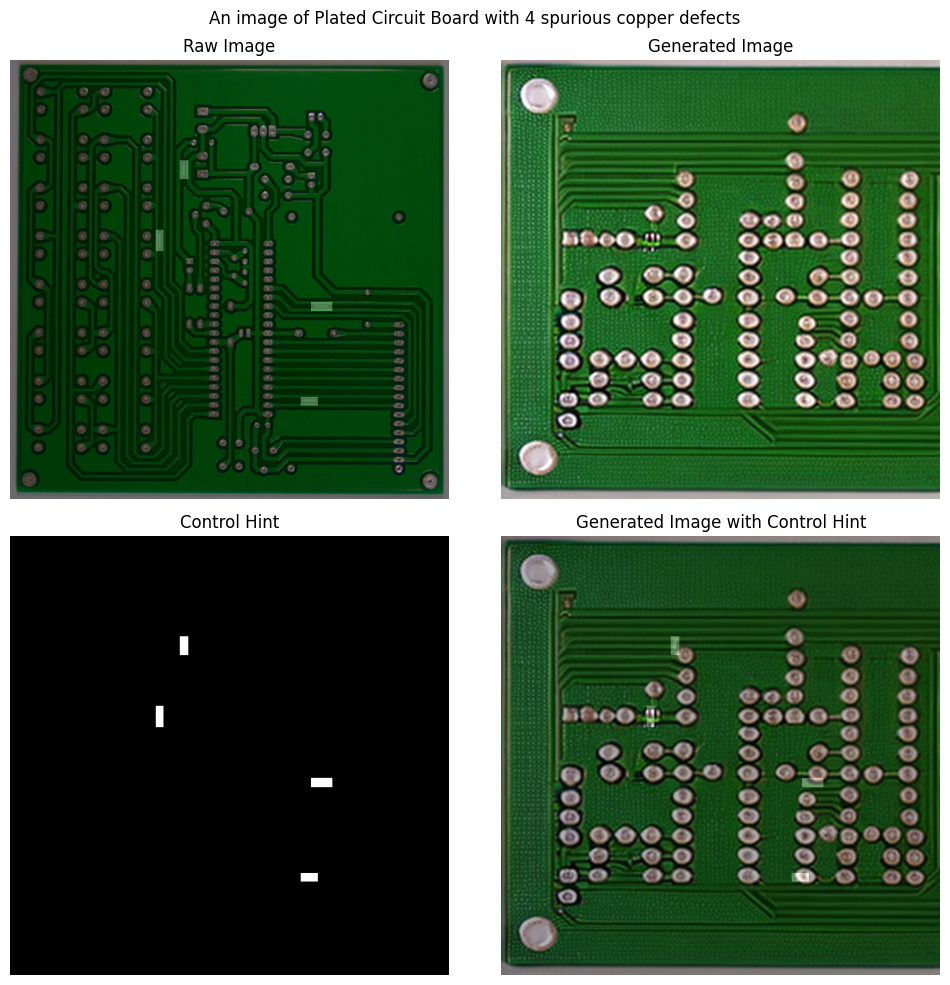

In [55]:
img_visualize = (data['jpg'] * 127.5 + 127.5).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.suptitle(data['txt'])
plt.subplot(2, 2, 1)
plt.title('Raw Image')
plt.imshow(img_visualize)
plt.imshow(data['hint'], alpha=0.3)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title('Generated Image')
plt.imshow(results[0])
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title('Control Hint')
plt.imshow(data['hint'])
plt.axis('off')
plt.subplot(2, 2, 4)
plt.title('Generated Image with Control Hint')
plt.imshow(results[0])
plt.imshow(data['hint'], alpha=0.3)
plt.axis('off')
plt.tight_layout()
plt.show()